<a href="https://colab.research.google.com/github/Dicti93/MLSEM/blob/master/5.%20Modelling%20/Modelling2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn imports for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import KNNImputer
from sklearn.metrics import average_precision_score, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Other Libraries
from scipy.stats import mstats
import copy
import tqdm

# Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.width', 240)

In [2]:
# Plotting Functions
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Blues", ax=ax, cbar=True)
    ax.set_ylabel('Actual label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)
    ax.set_aspect('equal')

def plot_model_results(subset, metrics, results):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

    # Table of metrics
    ax1 = axes[0]
    ax1.axis('off')
    table_data = [[metric, f"{value['mean']:.3f}", f"± {value['std']:.2f}"] for metric, value in metrics.items()]
    table = ax1.table(cellText=table_data, colLabels=["Metric", "Mean", "Std"], cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    ax1.set_title(subset)

    # Confusion matrix plot
    ax2 = axes[1]
    plot_confusion_matrix(results['cm'], "Confusion Matrix", ax2)

    plt.tight_layout()
    plt.show()

def plot_nnmodel_results(subset, metrics):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Table of metrics
    ax.axis('off')
    table_data = [[metric, f"{value['mean']:.3f}", f"± {value['std']:.2f}"] for metric, value in metrics.items()]
    table = ax.table(cellText=table_data, colLabels=["Metric", "Mean", "Std"], cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.5, 1.5)
    ax.set_title(subset)

    return fig

# Function to plot model comparison
def plot_model_comparison(title, model_results, subsets, metrics):
    colors = sns.color_palette("coolwarm", len(subsets))
    variables = {"Subset": subsets}
    for metric, metric_values in zip(metrics, model_results):
        variables[metric] = metric_values
    metrics_df = pd.DataFrame(variables)
    metrics_melted = metrics_df.melt(id_vars="Subset", var_name="Metric", value_name="Value")

    plt.figure(figsize=(12, 8))  # Increase figure size
    sns.barplot(data=metrics_melted, x="Metric", y="Value", hue="Subset", palette=colors)
    plt.title(title, fontsize=16)
    plt.xlabel("Metric", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)  # Rotate x-axis labels for better readability
    plt.yticks(fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
    plt.tight_layout()
    sns.set_style("whitegrid")
    sns.despine()
    plt.show()

In [3]:
# Scorer Functions
def sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    return sensitivity

def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return specificity

def auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true, y_pred)

sensitivity_scorer = make_scorer(sensitivity)
specificity_scorer = make_scorer(specificity)
auroc_scorer = make_scorer(auroc_scorer)
aucpr_scorer = make_scorer(aucpr_scorer)

In [4]:
# Scorer Functions for Neural Network
def calculate_sensitivity(y_true, y_pred):
    true_positive = torch.logical_and(y_true == 1, y_pred == 1).sum().item()
    actual_positive = (y_true == 1).sum().item()
    sensitivity = true_positive / actual_positive if actual_positive != 0 else 0
    return sensitivity

def calculate_specificity(y_true, y_pred):
    true_negative = torch.logical_and(y_true == 0, y_pred == 0).sum().item()
    actual_negative = (y_true == 0).sum().item()
    specificity = true_negative / actual_negative if actual_negative != 0 else 0
    return specificity

def calculate_auroc_scorer(y_true, y_pred):
    return roc_auc_score(y_true.detach().numpy(), y_pred.detach().numpy())

def calculate_aucpr_scorer(y_true, y_pred):
    return average_precision_score(y_true.detach().numpy(), y_pred.detach().numpy())

In [5]:
# Winsorization class for pipelines
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, lower=0.01, upper=0.99):
        self.columns = columns
        self.lower = lower
        self.upper = upper

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.columns is not None:
            for col in self.columns:
                if col in X_copy.columns:
                    X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])
        else:
            for col in X_copy.columns:
                X_copy[col] = mstats.winsorize(X_copy[col], limits=[self.lower, self.upper])
        return X_copy

In [6]:
!wget 'https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv' -O clean_data.csv

data = pd.read_csv('clean_data.csv')
data.shape

--2024-05-15 11:56:45--  https://raw.githubusercontent.com/Dicti93/MLSEM/master/3.%20Data%20Preparation/clean_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215867 (211K) [text/plain]
Saving to: ‘clean_data.csv’

clean_data.csv      100%[===================>] 210.81K  --.-KB/s    in 0.03s   

2024-05-15 11:56:45 (6.22 MB/s) - ‘clean_data.csv’ saved [215867/215867]



(780, 52)

In [7]:
# Defining Sets

extreme_outlier = [
    "BMI",
    "Body_Temperature"
]

restricted = [
    "Length_of_Stay",
    "Alvarado_Score",
    "Ipsilateral_Rebound_Tenderness",
    "Paedriatic_Appendicitis_Score",
    "Peritonitis",
    "Nausea",
    "Migratory_Pain"
]

partially_restricted = [
    "Length_of_Stay",
    "Alvarado_Score",
    "Ipsilateral_Rebound_Tenderness",
    "WBC_Count",
    "CRP",
    "Paedriatic_Appendicitis_Score",
    "Neutrophil_Percentage",
    "Segmented_Neutrophils"
]

unrestricted = [
    'Appendix_Diameter',
    'Length_of_Stay',
    'Surrounding_Tissue_Reaction',
    'Alvarado_Score',
    'Ipsilateral_Rebound_Tenderness',
    'Appendix_on_US',
    'WBC_Count',
    'CRP'
]

complete = ['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Alvarado_Score', 'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter', 'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea', 'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count', 'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia', 'RBC_Count', 'Hemoglobin', 'RDW',
       'Thrombocyte_Count', 'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria', 'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness', 'US_Performed', 'Free_Fluids', 'Appendix_Wall_Layers', 'Target_Sign',
       'Appendicolith', 'Perfusion', 'Perforation', 'Surrounding_Tissue_Reaction', 'Appendicular_Abscess', 'Pathological_Lymph_Nodes', 'Bowel_Wall_Thickening', 'Conglomerate_of_Bowel_Loops', 'Ileus', 'Coprostasis', 'Meteorism',
       'Enteritis', 'Gynecological_Findings']

TARGET = "Diagnosis"

sets = [restricted, partially_restricted, unrestricted, complete]
set_names = [
    "Restricted Dataset: Subset of Demographic + Scoring + Clinical",
    "Partially Restricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory",
    "Unrestricted Dataset: Subset of Demographic + Scoring + Clinical + Laboratory + Ultrasound",
    "Complete Dataset: all variables"
]

# Prepare results for plotting
metrics = ["Accuracy", "ROC", "AUCPR", "Sensitivity", "Specificity"]
subsets = [
    "Restricted Dataset",
    "Partially Restricted Dataset",
    "Unrestricted Dataset",
    "Complete Dataset"
]

In [8]:
# Number of neighbors for KNN imputation
k=24

# Model evaluation function
def evaluate_model(model_pipeline, X, y, splits=10):
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)
    y_pred_cv = cross_val_predict(model_pipeline, X, y, cv=k_fold)
    cm = confusion_matrix(y, y_pred_cv)
    cm = cm / splits
    cm = np.round(cm, 0).astype(int)

    metrics = {}
    metrics["Accuracy"] = {
        "mean": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring="accuracy").mean(),
        "std": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring="accuracy").std()
    }
    metrics["ROC"] = {
        "mean": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring=auroc_scorer).mean(),
        "std": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring=auroc_scorer).std()
    }
    metrics["AUCPR"] = {
        "mean": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer).mean(),
        "std": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring=aucpr_scorer).std()
    }
    metrics["Sensitivity"] = {
        "mean": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring="recall").mean(),
        "std": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring="recall").std()
    }
    metrics["Specificity"] = {
        "mean": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring=specificity_scorer).mean(),
        "std": cross_val_score(model_pipeline, X, y, cv=k_fold, scoring=specificity_scorer).std()
    }

    results = {"cm": cm, "metrics": metrics}
    return results

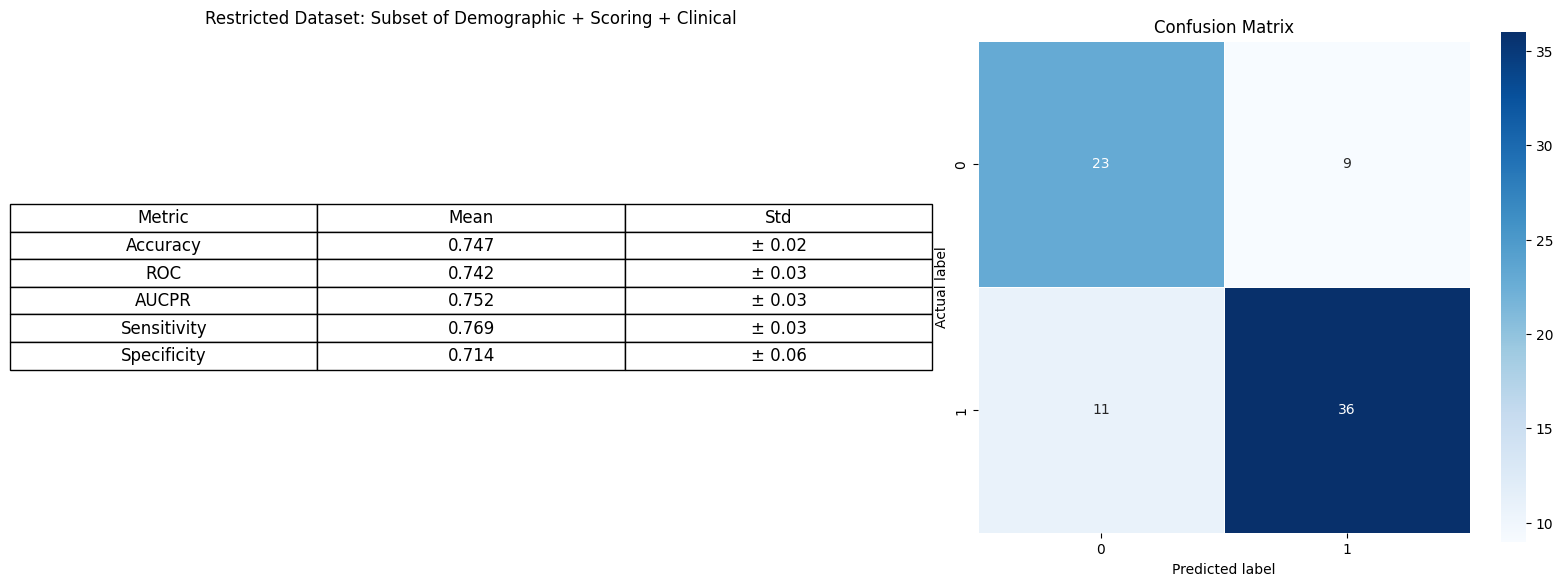

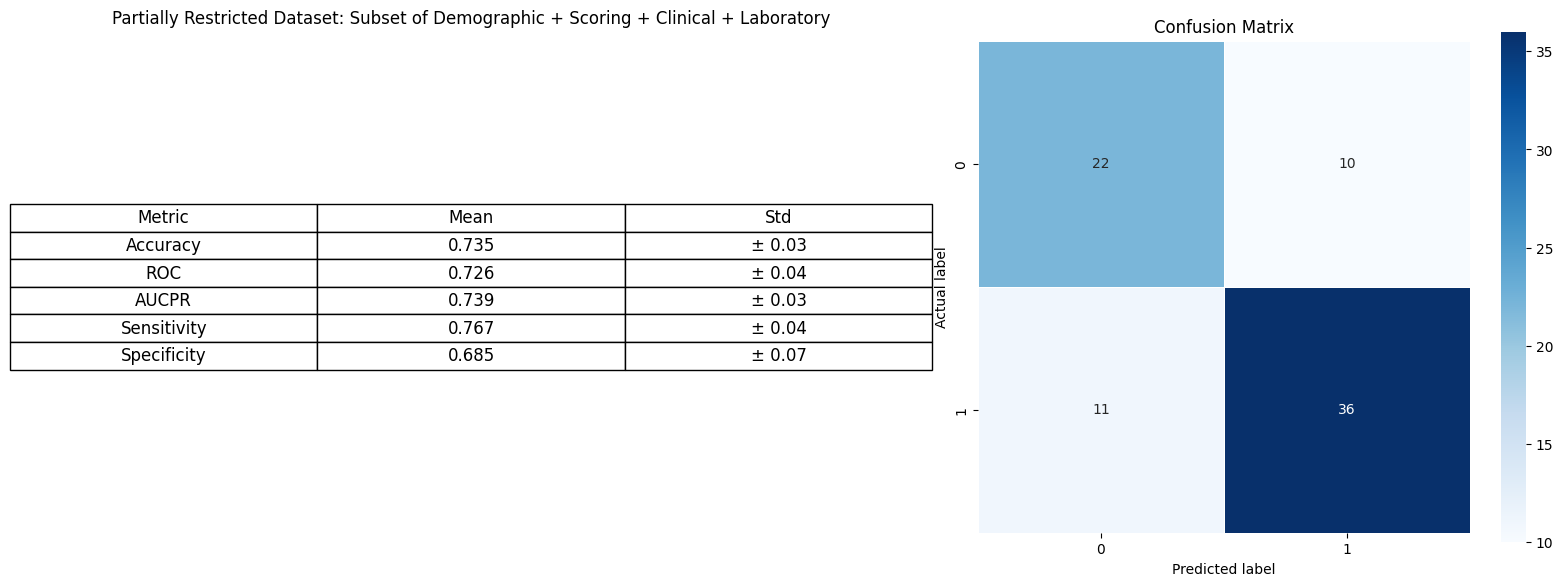

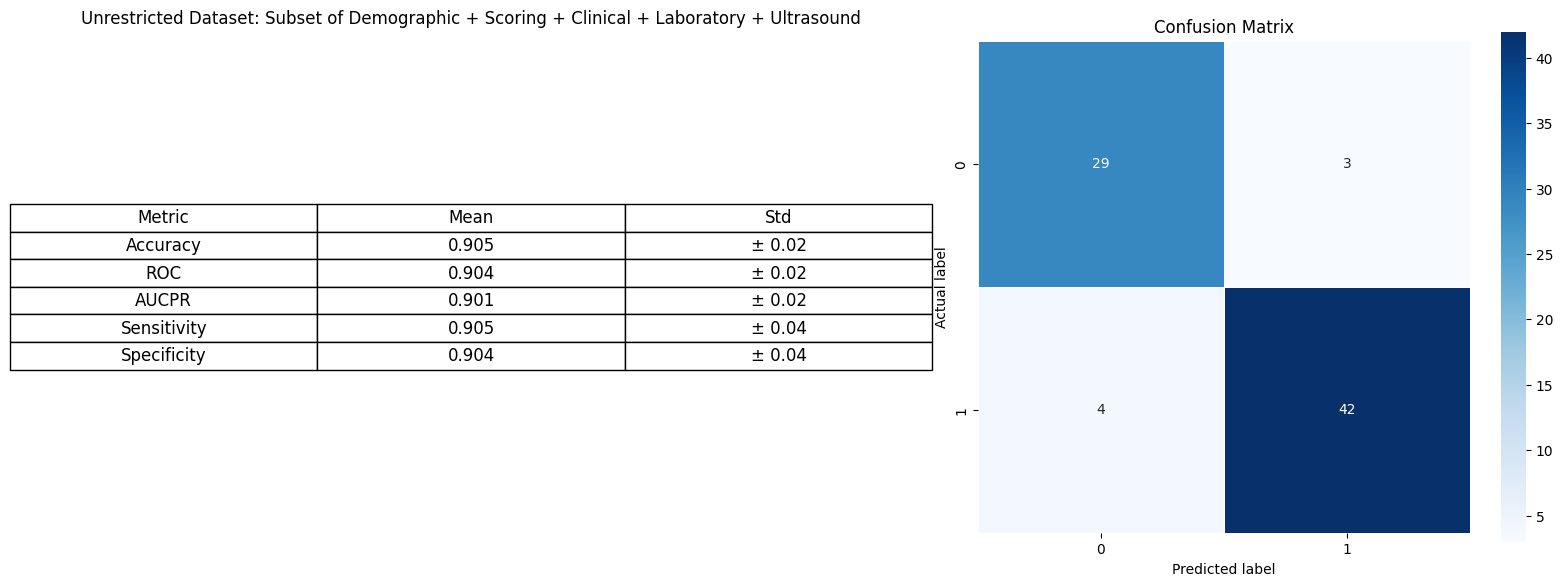

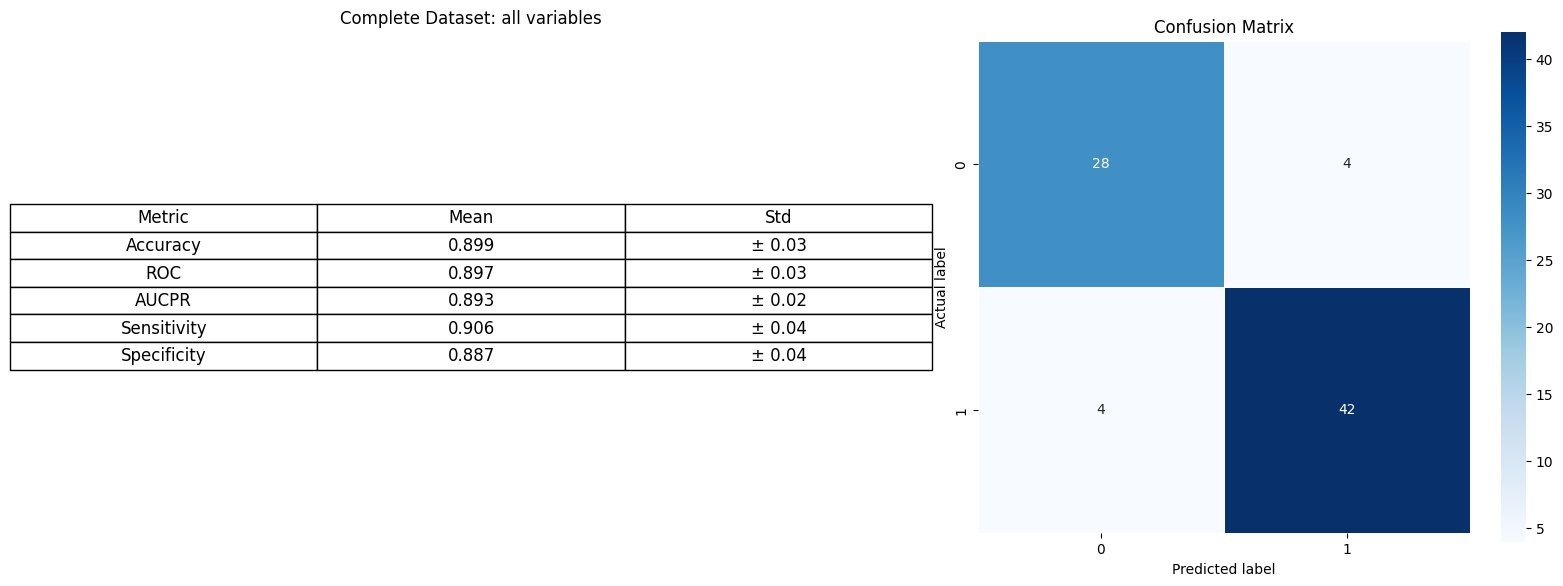

In [9]:
# Logistic Regression
lr_results = []
for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    subset = set_names[index]
    lr_model = LogisticRegression(max_iter=1000, random_state=123)
    lr_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=k)),
        ('classifier', lr_model)
    ])
    results = evaluate_model(lr_pipeline, X, y)
    plot_model_results(subset, results["metrics"], results)
    lr_results.append(results["metrics"])

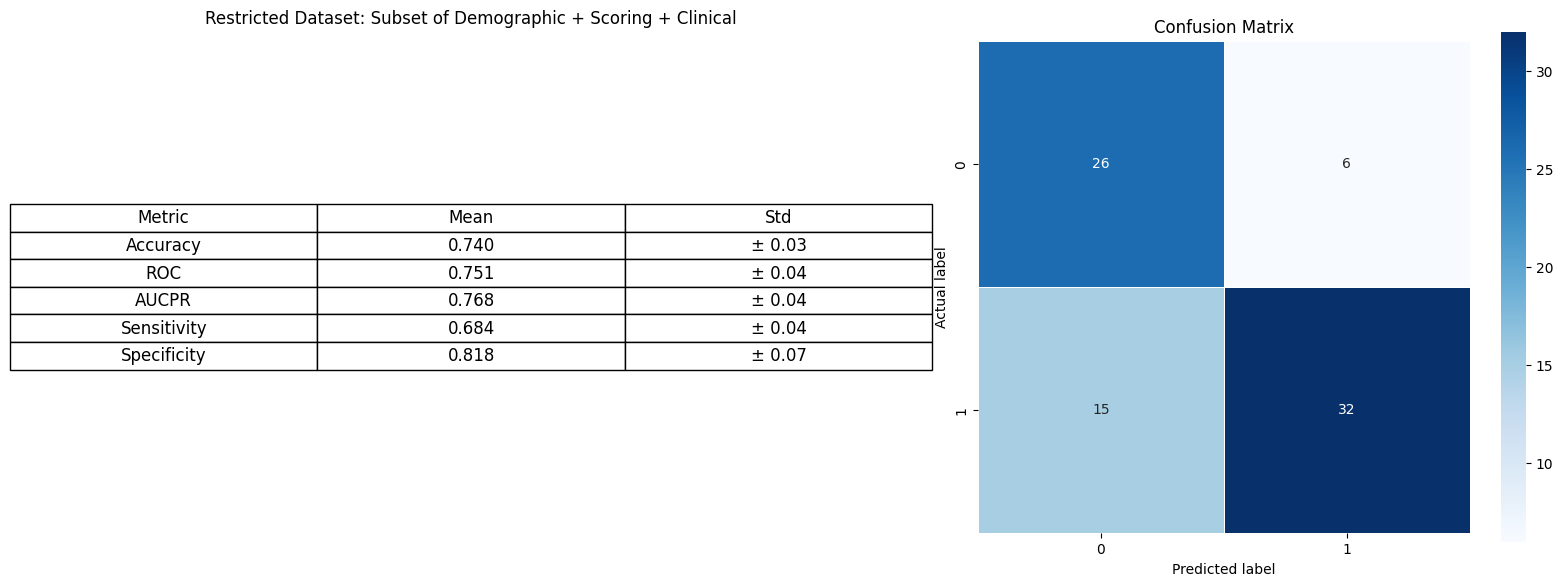

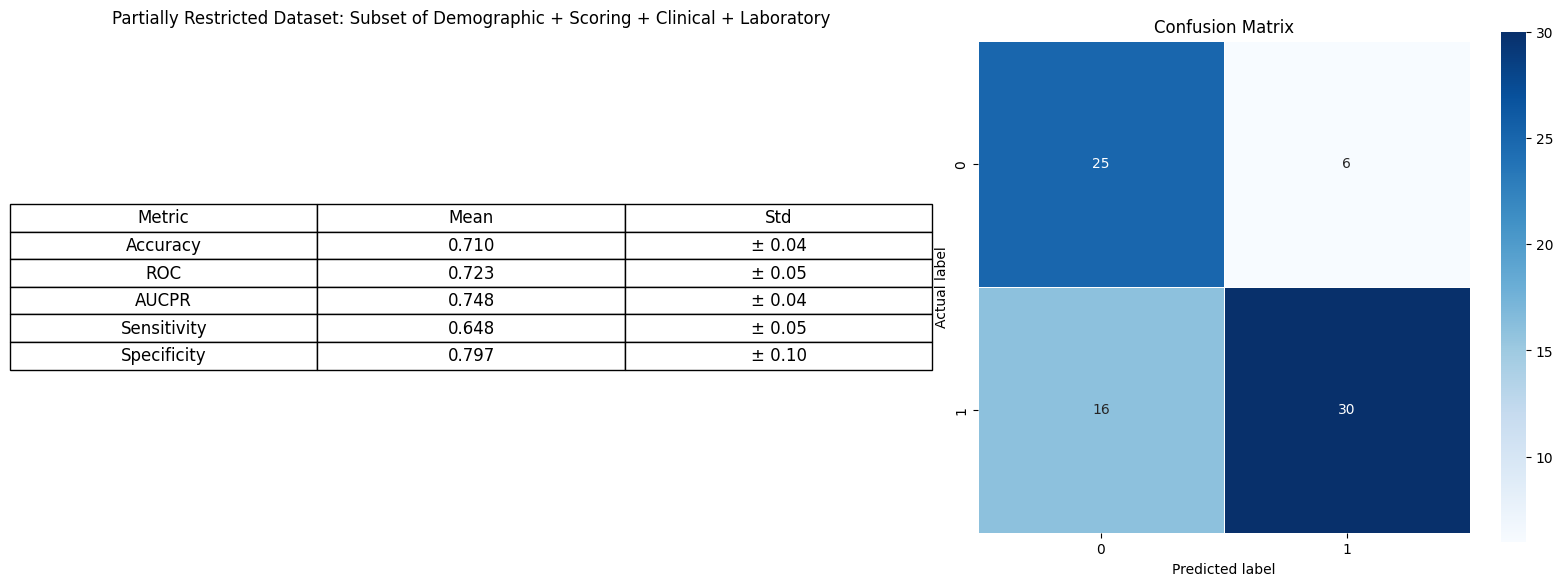

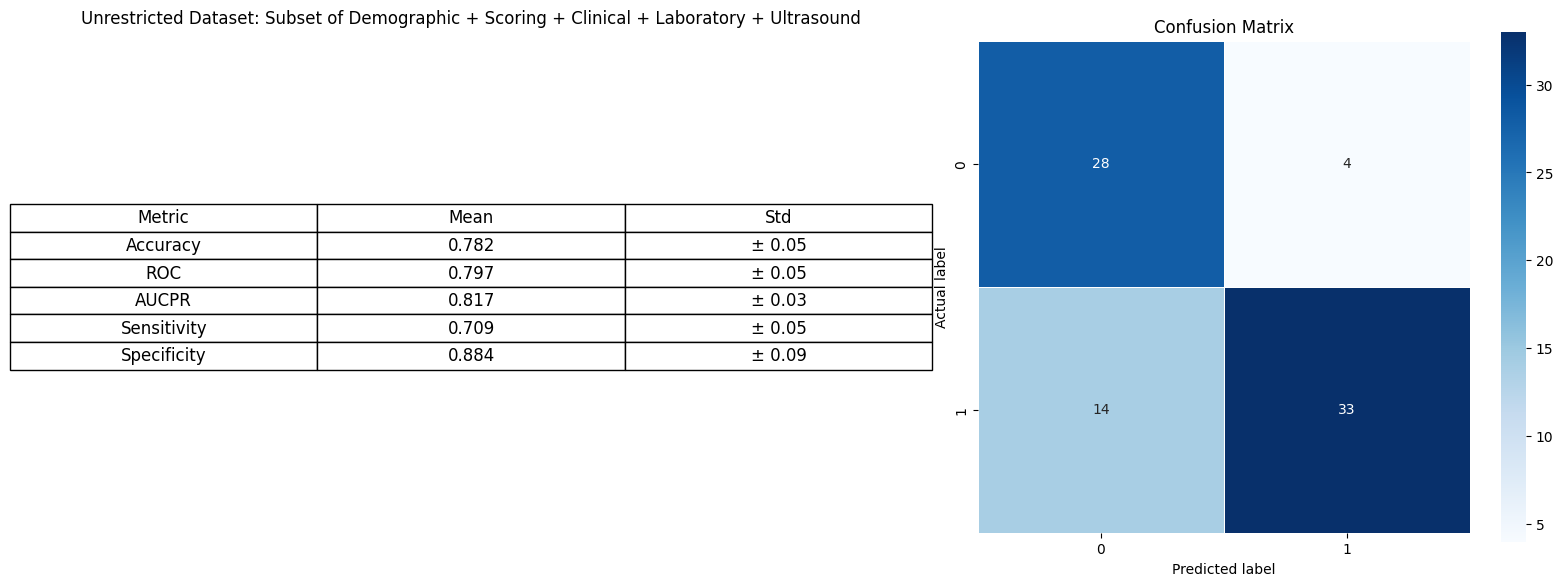

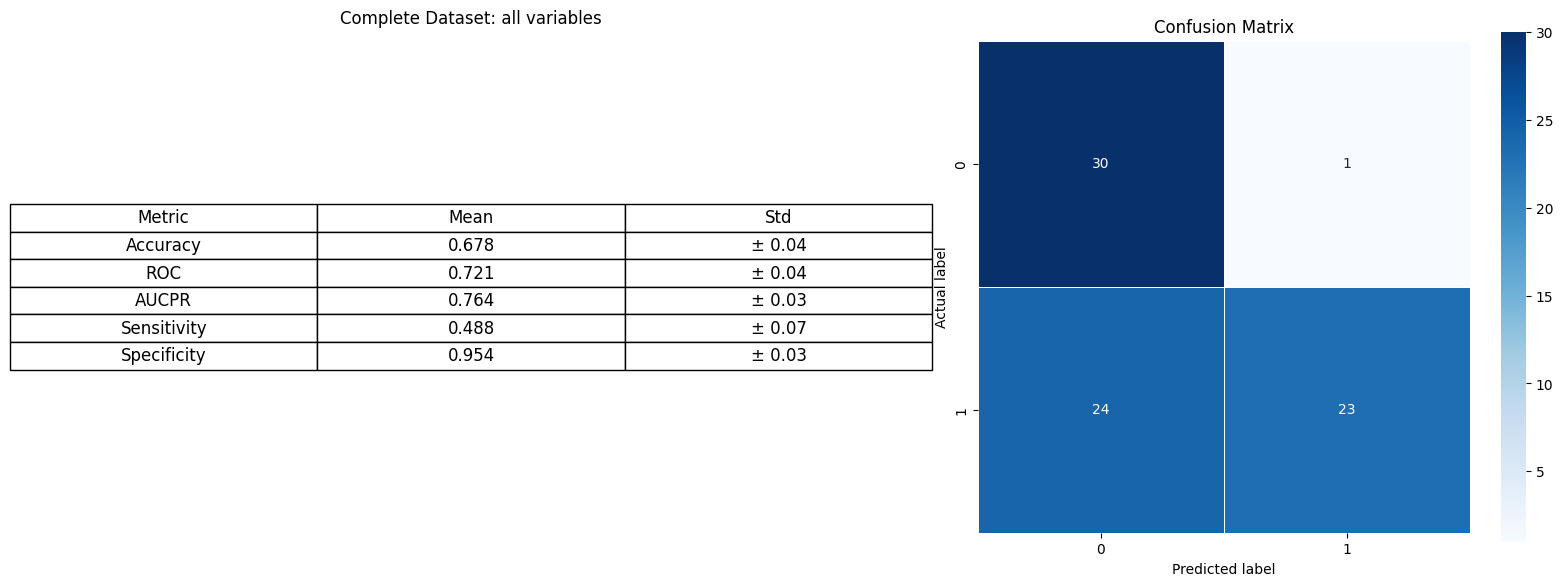

In [10]:
# Naive Bayes Classifier
nb_results = []
for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    subset = set_names[index]
    nb_model = GaussianNB()
    nb_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=k)),
        ('classifier', nb_model)
    ])
    results = evaluate_model(nb_pipeline, X, y)
    plot_model_results(subset, results["metrics"], results)
    nb_results.append(results["metrics"])

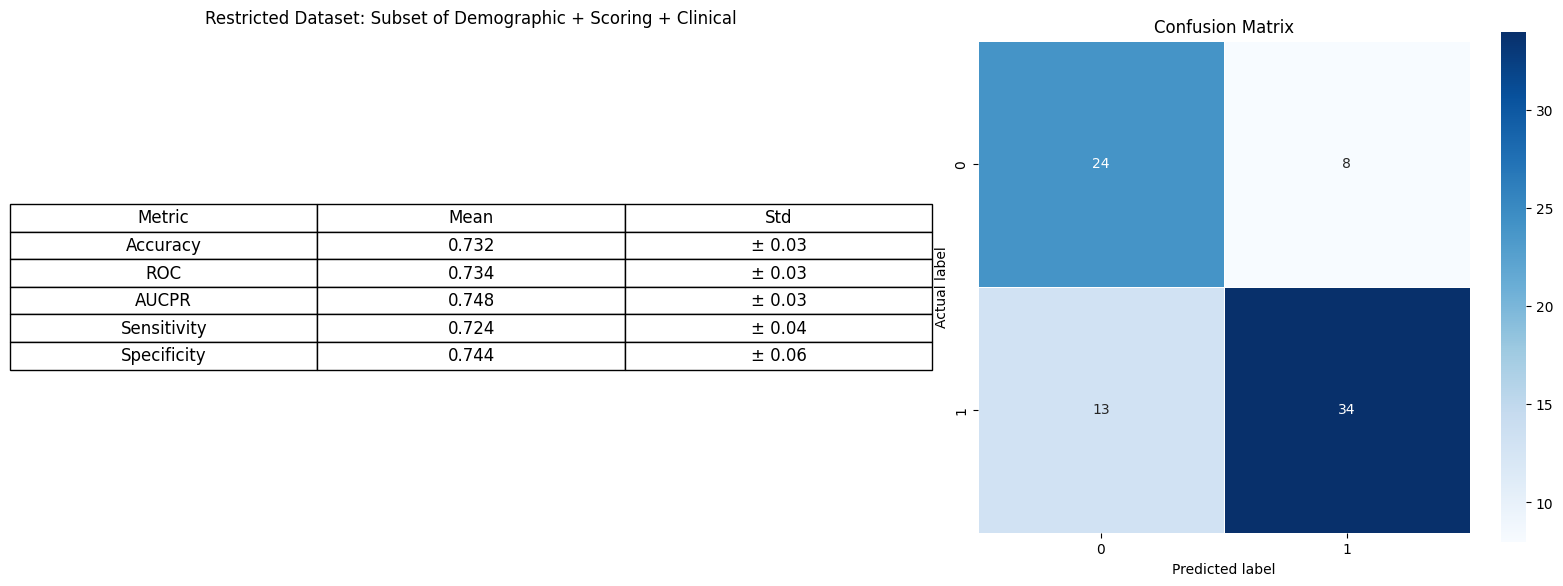

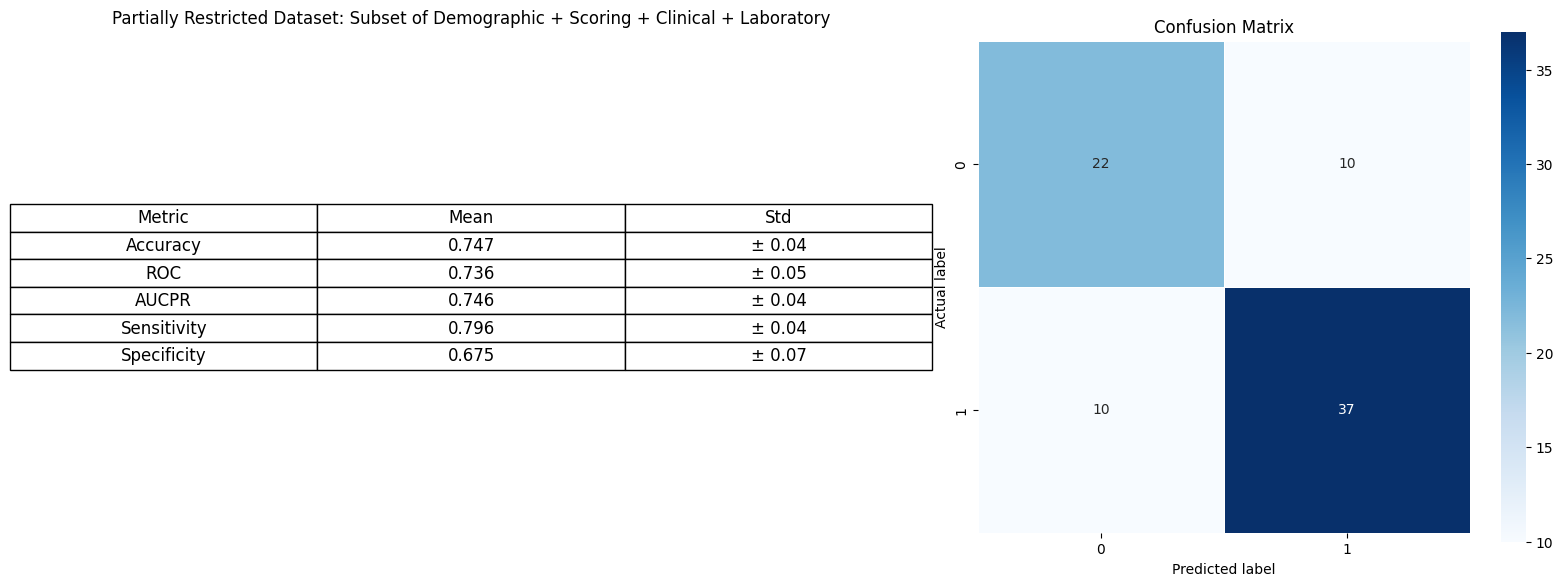

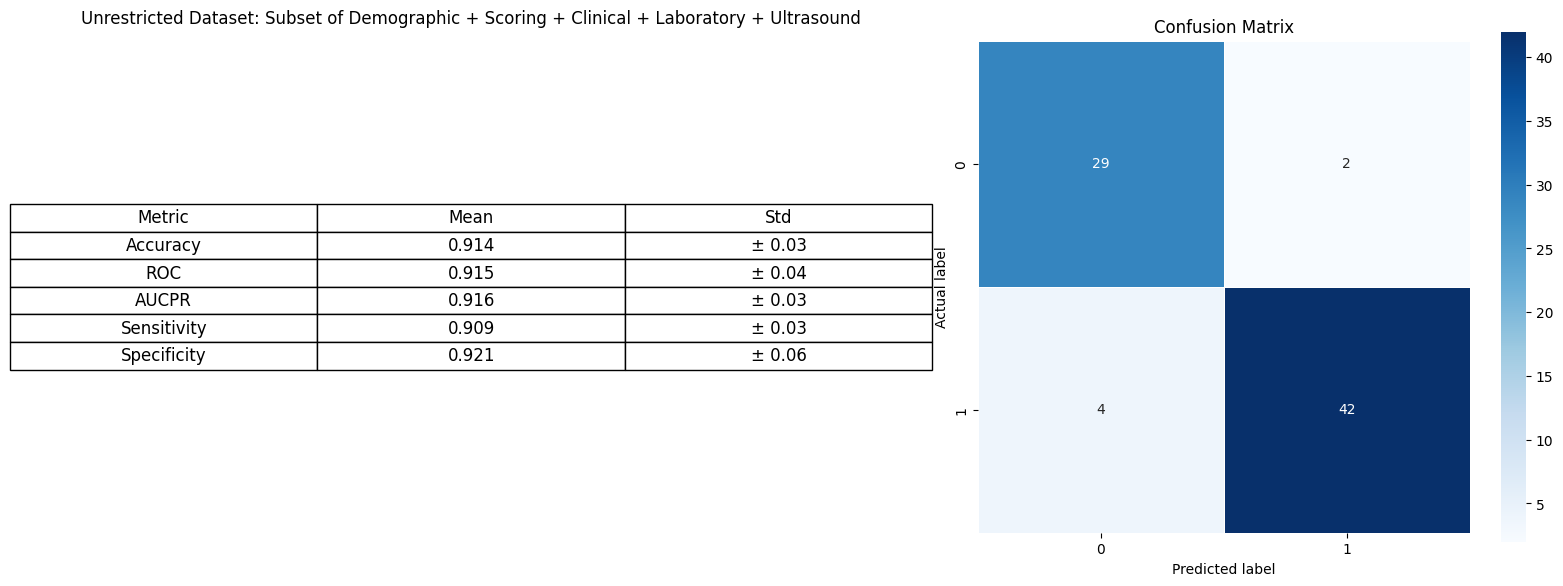

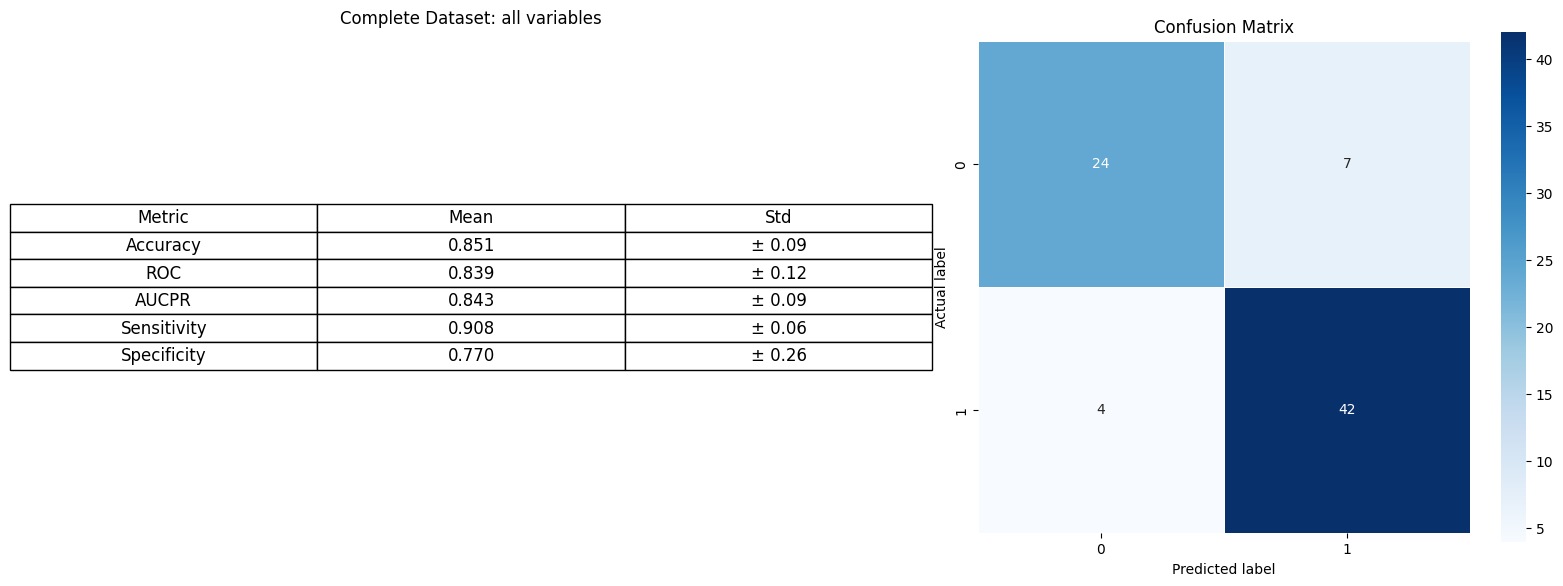

In [11]:
# Support Vector Machine
svm_results = []
for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    subset = set_names[index]
    svm_model = SVC(kernel='rbf', random_state=123, probability=True)
    svm_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=k)),
        ('classifier', svm_model)
    ])
    results = evaluate_model(svm_pipeline, X, y)
    plot_model_results(subset, results["metrics"], results)
    svm_results.append(results["metrics"])

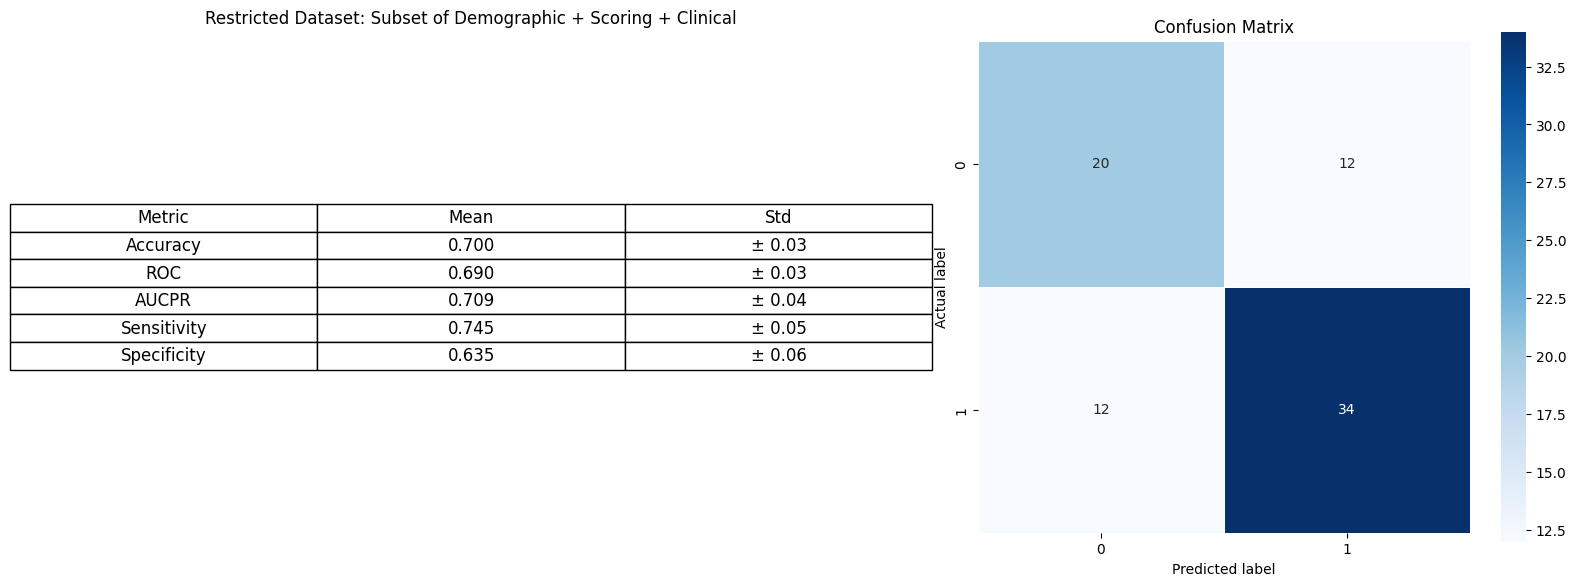

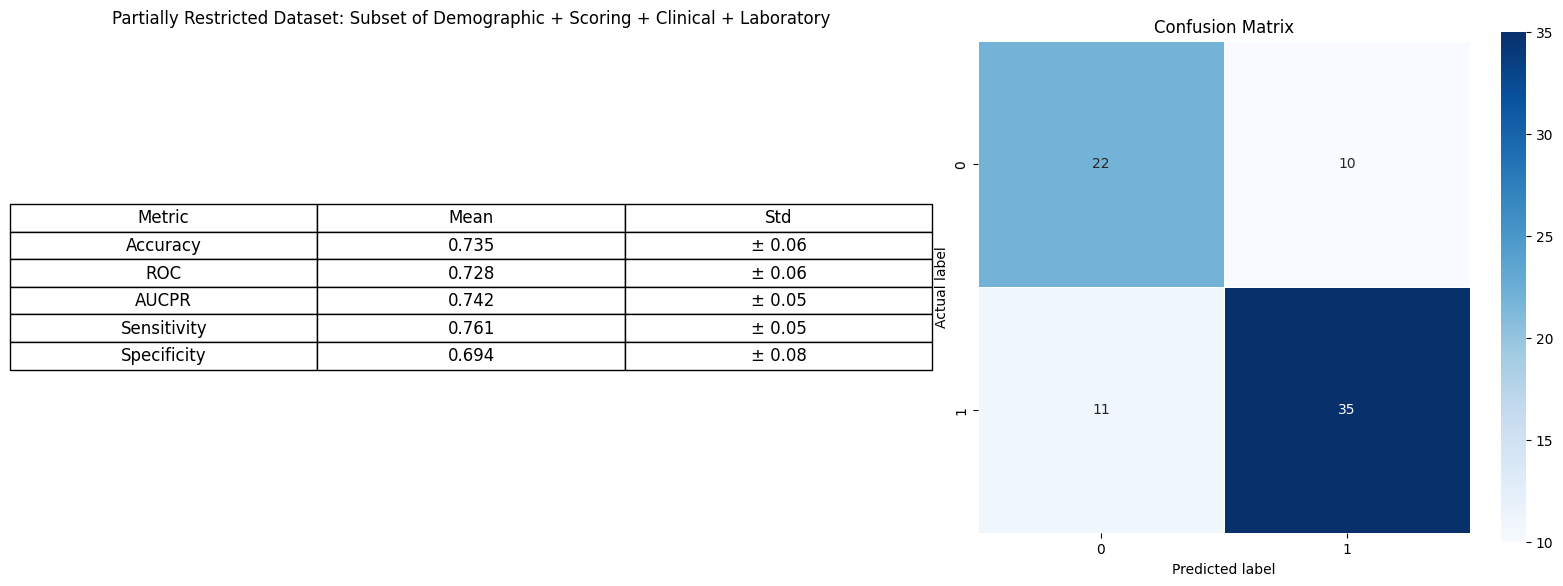

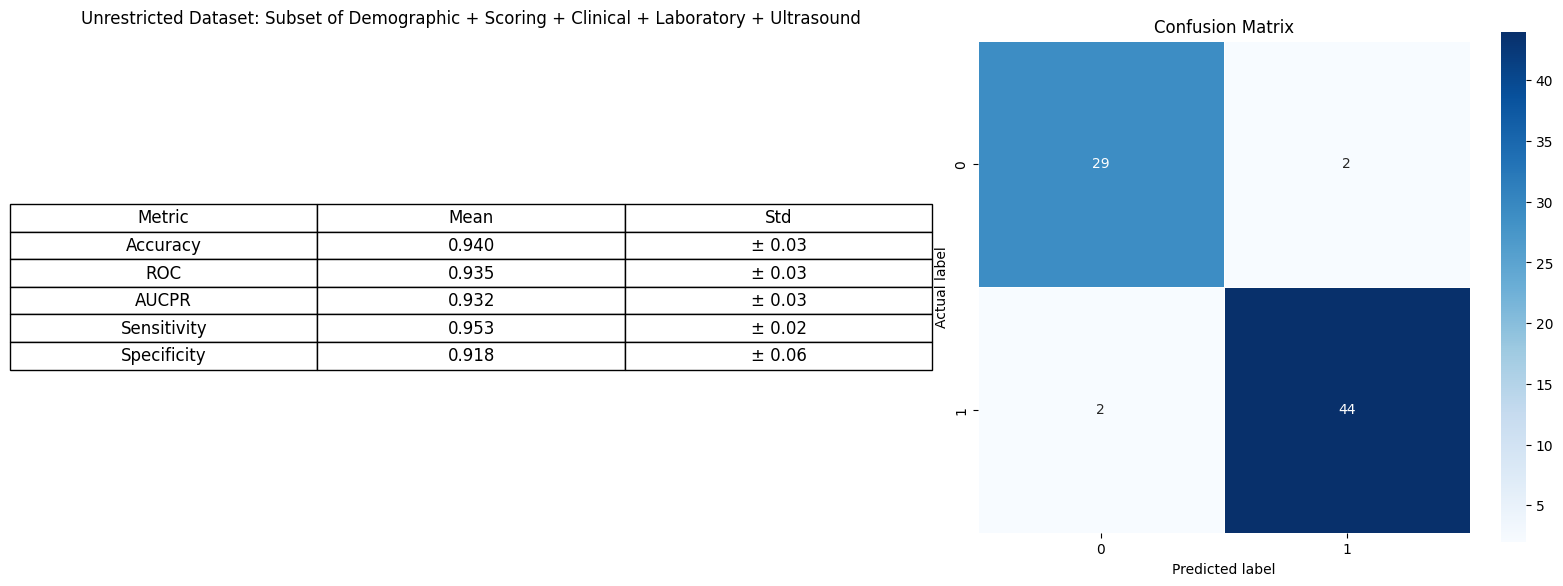

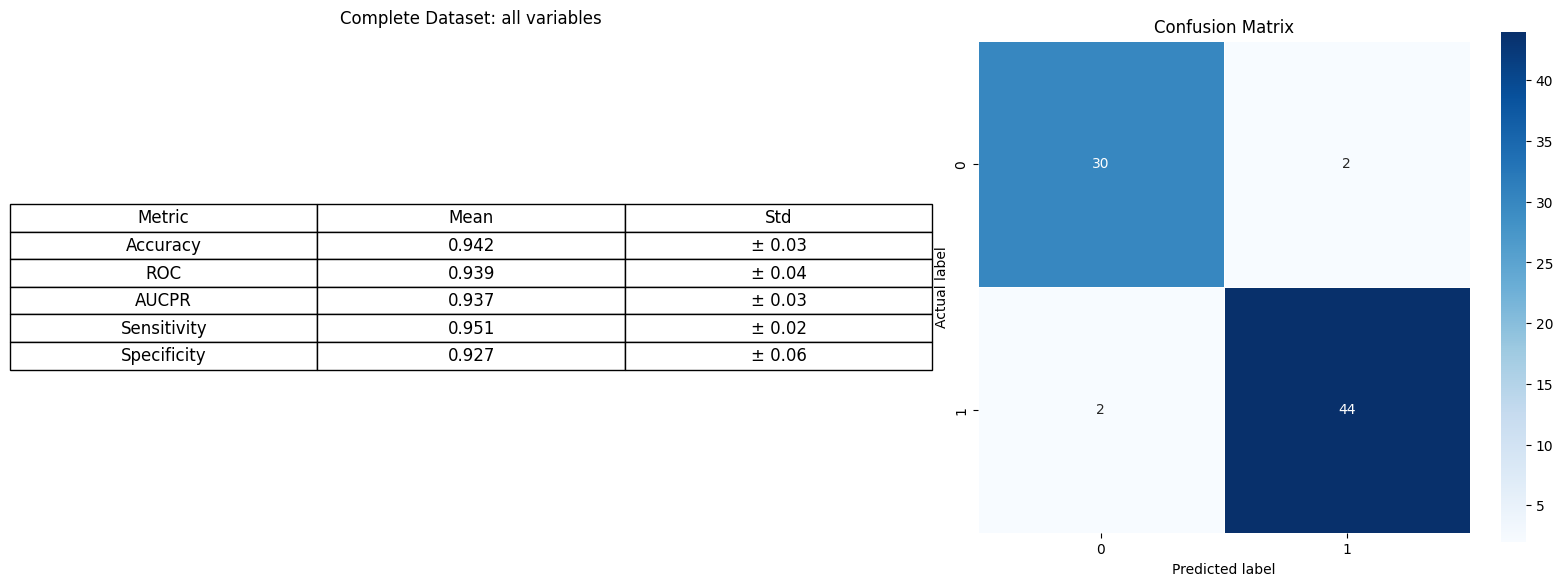

In [12]:
# Random Forest Classifier
rf_results = []
for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    subset = set_names[index]
    rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
    rf_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=k)),
        ('classifier', rf_model)
    ])
    results = evaluate_model(rf_pipeline, X, y)
    plot_model_results(subset, results["metrics"], results)
    rf_results.append(results["metrics"])

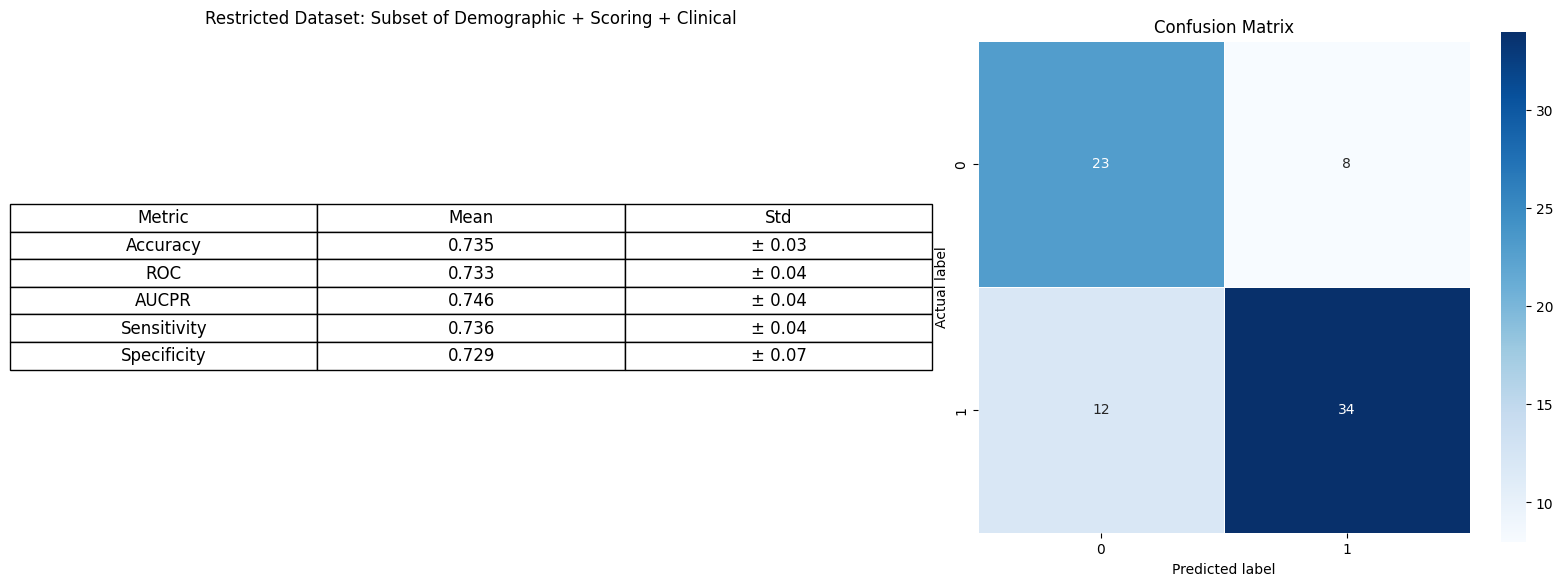

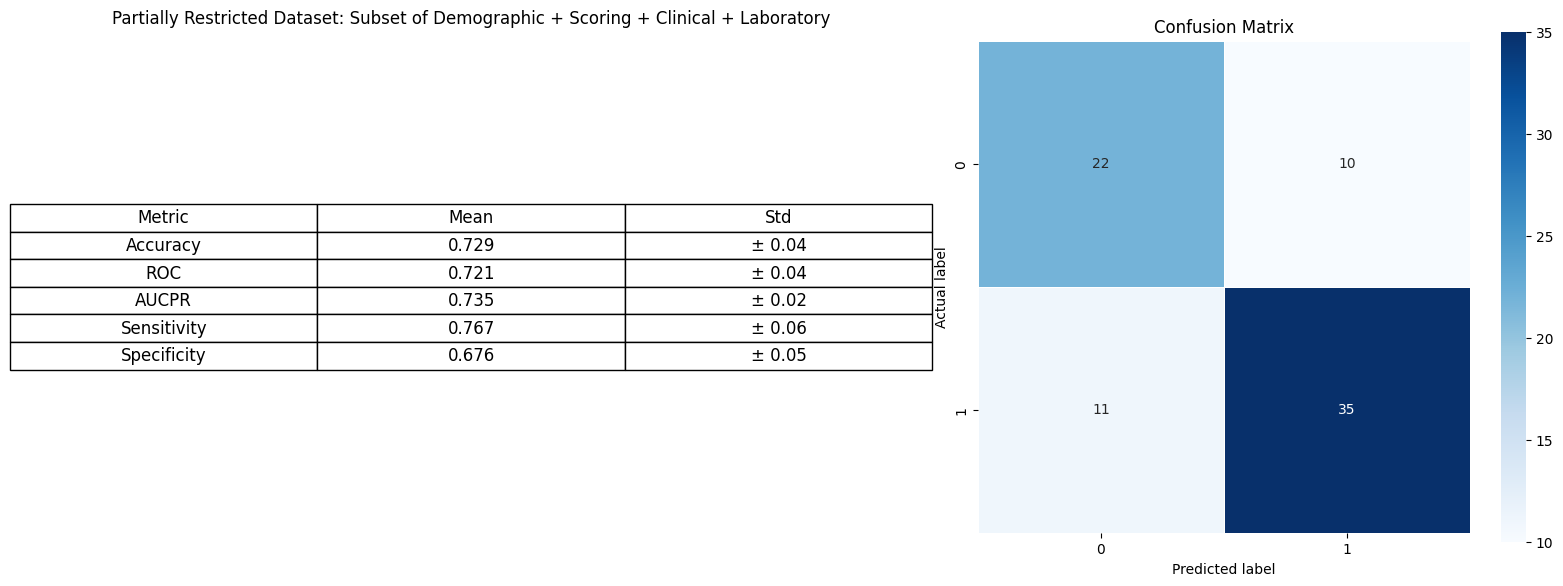

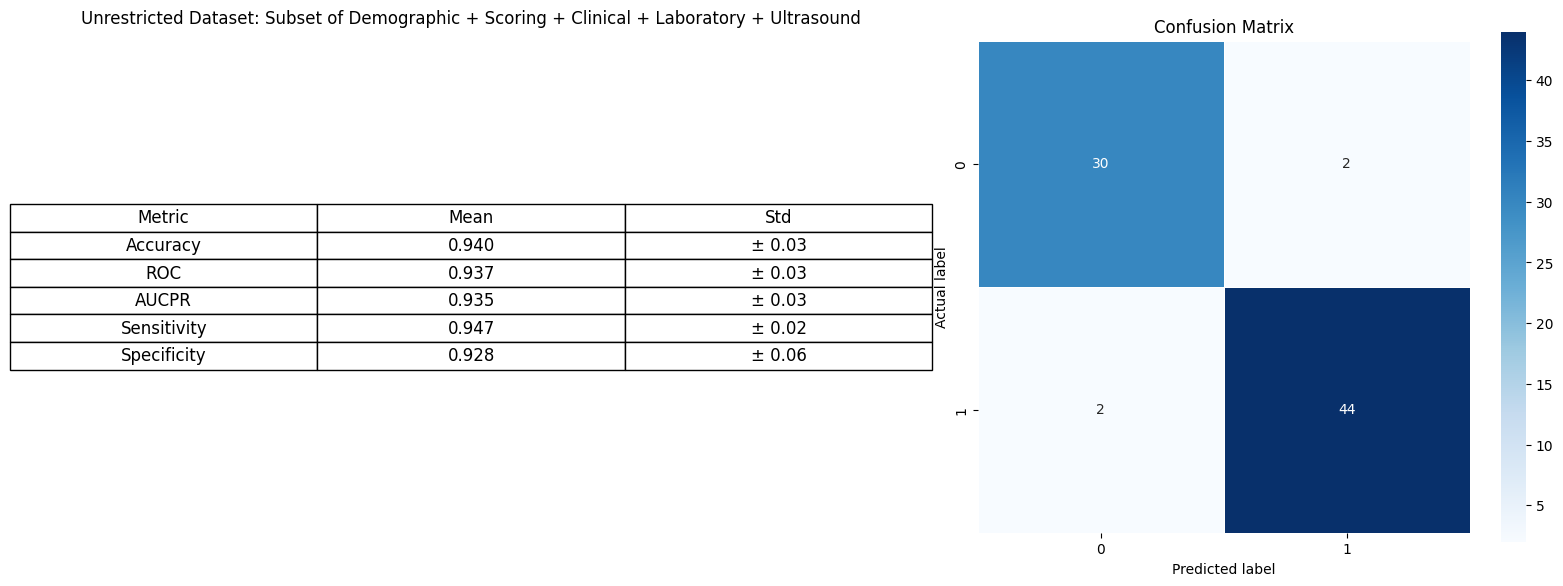

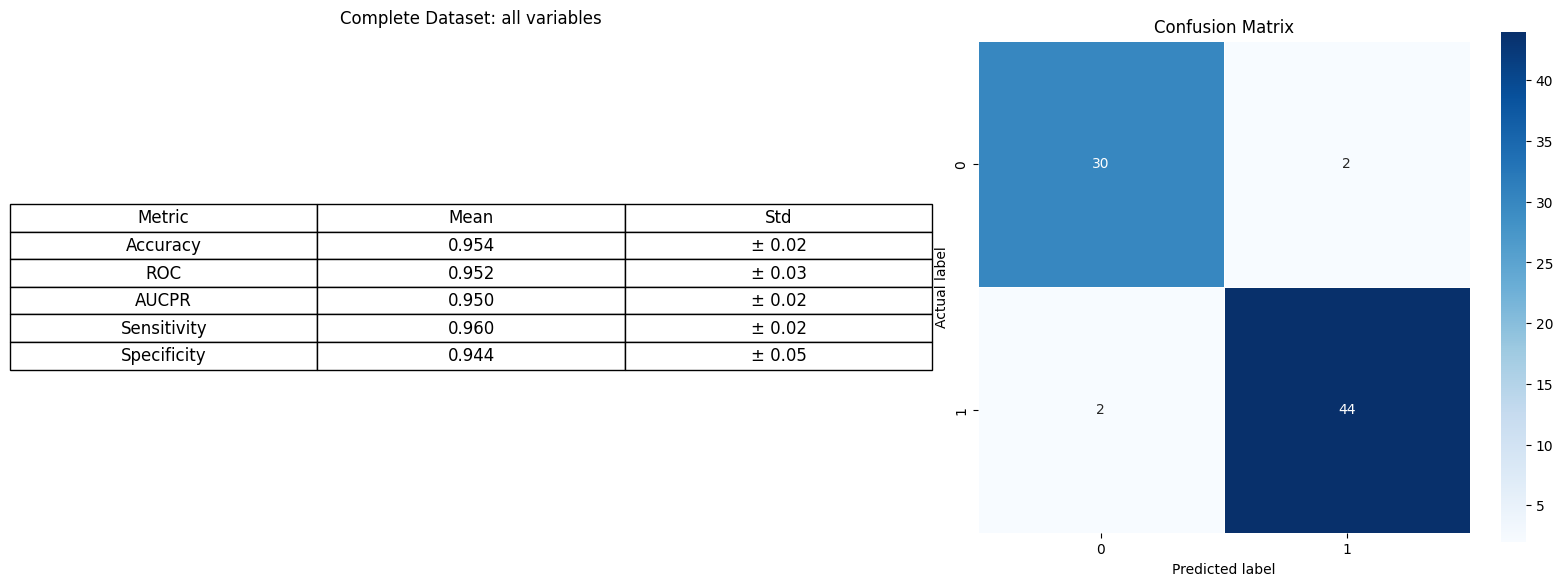

In [13]:
# Gradient Boosting Classifier
gb_results = []
for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    subset = set_names[index]
    gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=123)
    gbm_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=k)),
        ('classifier', gbm_model)
    ])
    results = evaluate_model(gbm_pipeline, X, y)
    plot_model_results(subset, results["metrics"], results)
    gb_results.append(results["metrics"])

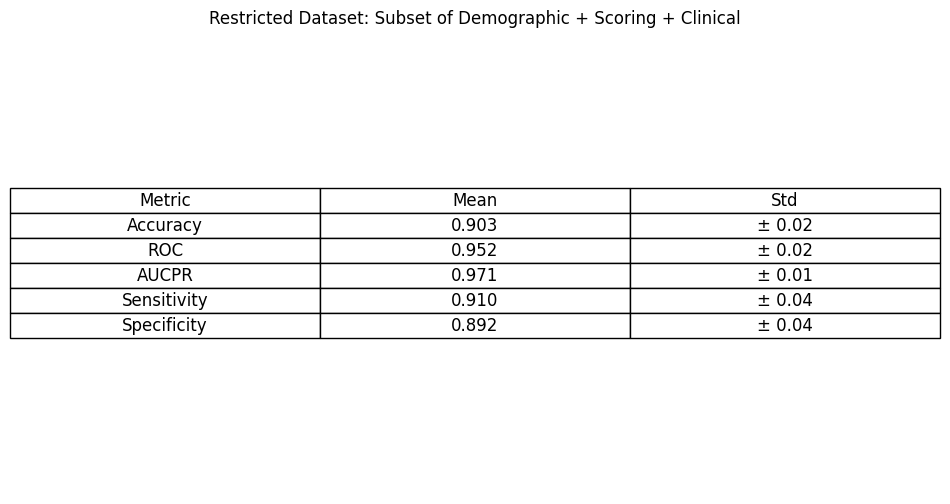

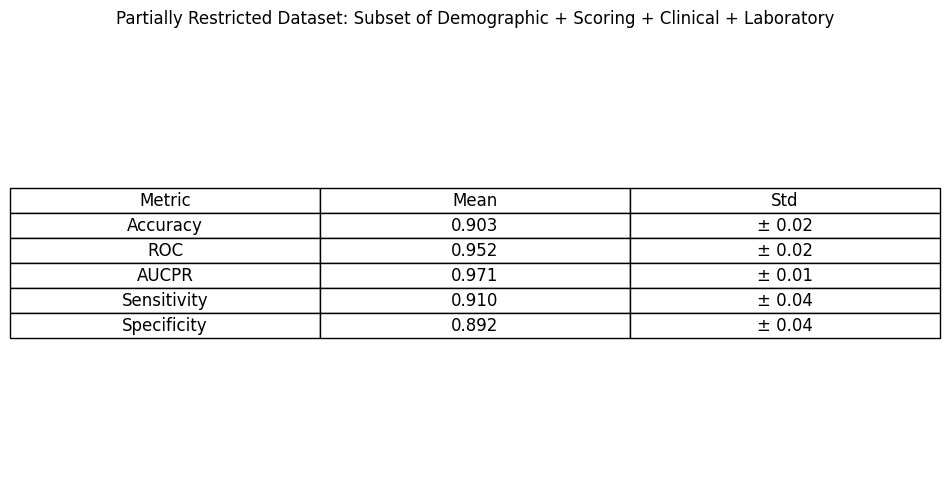

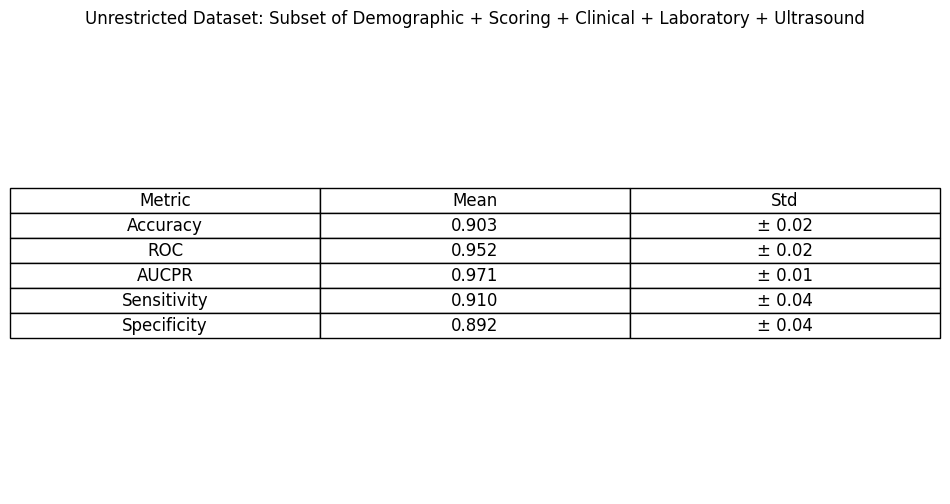

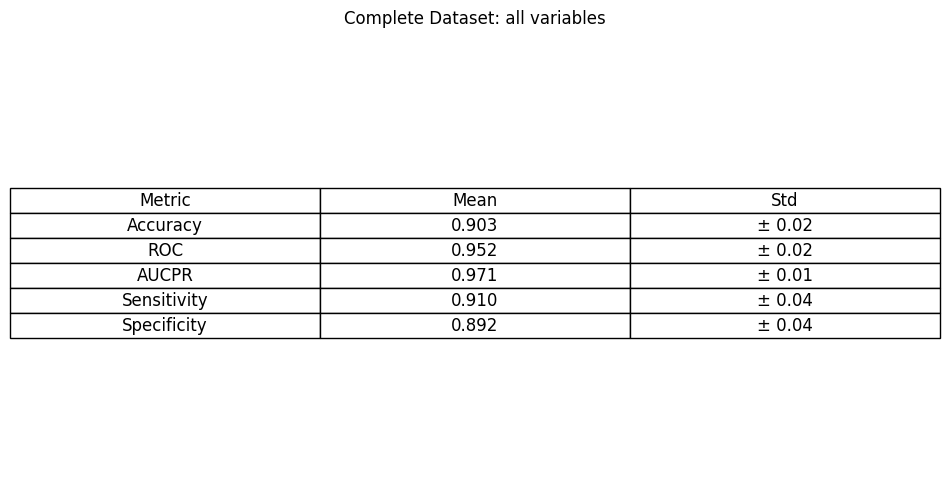

In [14]:
# Neural Network
nn_results = []
for index, features in enumerate(sets):
    X = data[features]
    y = data[TARGET]
    subset = set_names[index]
    nn_pipeline = Pipeline([
        ('winsorizer', Winsorizer(columns=extreme_outlier)),
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=k))
    ])
    X_nn = nn_pipeline.fit_transform(X)
    X_nn = torch.tensor(X_nn, dtype=torch.float32)
    y_nn = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float32)

    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.hidden = nn.Linear(X.shape[1], 128)
            self.relu = nn.ReLU()
            self.layer2 = nn.Linear(128, 64)
            self.act2 = nn.ReLU()
            self.output = nn.Linear(64, 1)
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.relu(self.hidden(x))
            x = self.act2(self.layer2(x))
            x = self.sigmoid(self.output(x))
            return x

    def model_train(model, X_train, y_train, X_val, y_val):
        loss_func = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        n_epochs = 50
        batch_size = 10
        batch_start = torch.arange(0, len(X_train), batch_size)

        best_acc = -np.inf
        best_weights = None
        best_sensitivity = 0
        best_specificity = 0
        best_auroc = 0
        best_aucpr = 0

        for epoch in range(n_epochs):
            model.train()
            with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
                bar.set_description(f"Epoch {epoch}")
                for start in bar:
                    X_batch = X_train[start:start+batch_size]
                    y_batch = y_train[start:start+batch_size]
                    y_pred = model(X_batch)
                    loss = loss_func(y_pred, y_batch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    acc = (y_pred.round() == y_batch).float().mean()
                    bar.set_postfix(loss=float(loss), acc=float(acc))
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            sensitivity = calculate_sensitivity(y_val, y_pred.round())
            specificity = calculate_specificity(y_val, y_pred.round())
            auroc = calculate_auroc_scorer(y_val, y_pred)
            aucpr = calculate_aucpr_scorer(y_val, y_pred)

            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
                best_sensitivity = sensitivity
                best_specificity = specificity
                best_auroc = auroc
                best_aucpr = aucpr

        model.load_state_dict(best_weights)
        return best_acc, best_auroc, best_aucpr, best_sensitivity, best_specificity

    splits = 10
    k_fold = KFold(n_splits=splits, shuffle=True, random_state=123)
    cv_scores_accuracy = []
    cv_scores_auroc = []
    cv_scores_aucpr = []
    cv_scores_sensitivity = []
    cv_scores_specificity = []

    for train, test in k_fold.split(X_nn, y_nn):
        model = NeuralNetwork()
        results = model_train(model, X_nn[train], y_nn[train], X_nn[test], y_nn[test])
        cv_scores_accuracy.append(results[0])
        cv_scores_auroc.append(results[1])
        cv_scores_aucpr.append(results[2])
        cv_scores_sensitivity.append(results[3])
        cv_scores_specificity.append(results[4])

    metrics = {
        "Accuracy": {"mean": np.mean(cv_scores_accuracy), "std": np.std(cv_scores_accuracy)},
        "ROC": {"mean": np.mean(cv_scores_auroc), "std": np.std(cv_scores_auroc)},
        "AUCPR": {"mean": np.mean(cv_scores_aucpr), "std": np.std(cv_scores_aucpr)},
        "Sensitivity": {"mean": np.mean(cv_scores_sensitivity), "std": np.std(cv_scores_sensitivity)},
        "Specificity": {"mean": np.mean(cv_scores_specificity), "std": np.std(cv_scores_specificity)}
    }
    nn_results.append(metrics)

for index, features in enumerate(sets):
    subset = set_names[index]
    fig = plot_nnmodel_results(subset, metrics)
    plt.show()

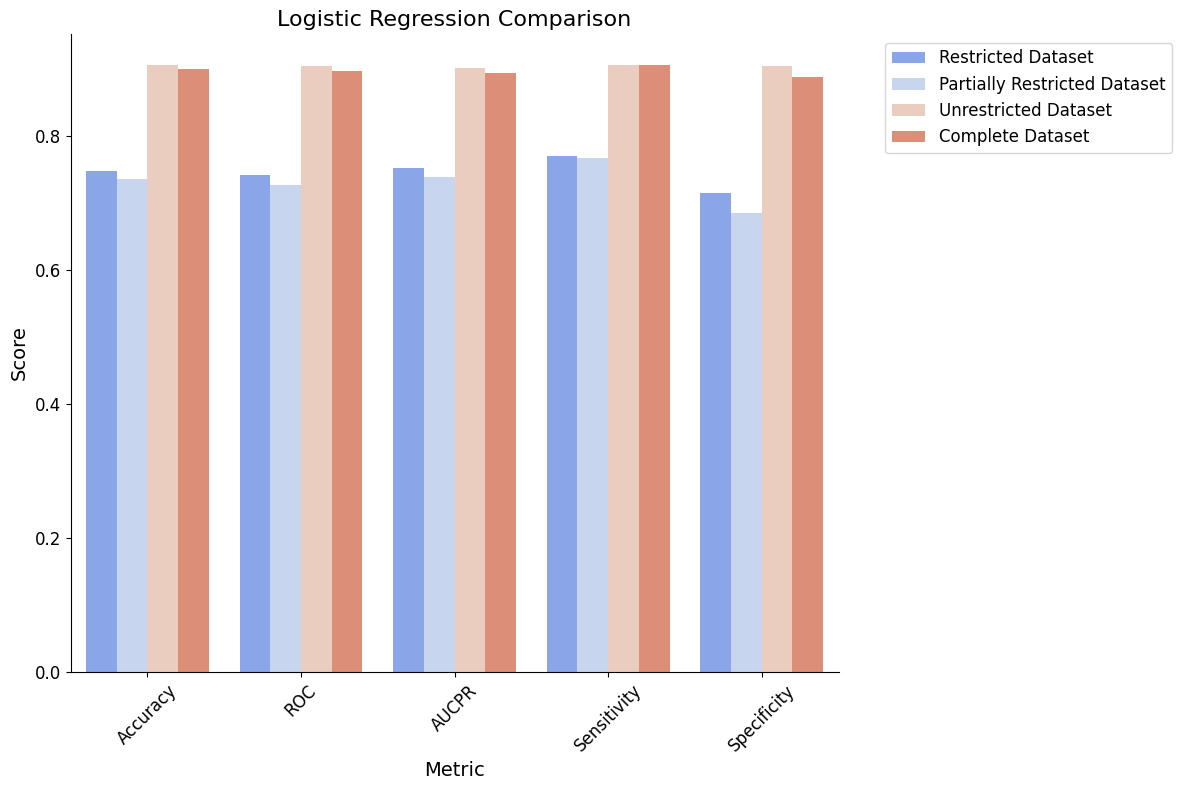

In [15]:
# Logistic Regression Results
lr_metrics = {
    "Accuracy": [res["Accuracy"]["mean"] for res in lr_results],
    "ROC": [res["ROC"]["mean"] for res in lr_results],
    "AUCPR": [res["AUCPR"]["mean"] for res in lr_results],
    "Sensitivity": [res["Sensitivity"]["mean"] for res in lr_results],
    "Specificity": [res["Specificity"]["mean"] for res in lr_results],
}
plot_model_comparison("Logistic Regression Comparison", lr_metrics.values(), subsets, metrics)

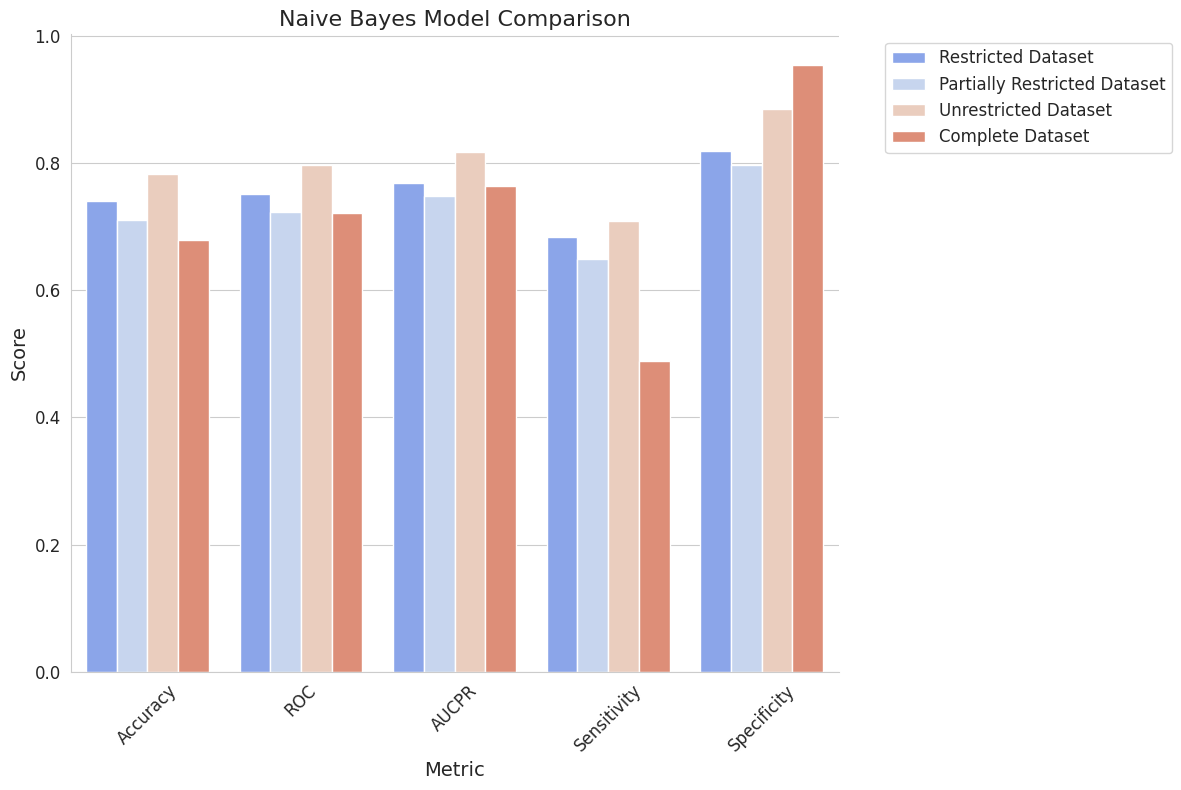

In [16]:
# Naive Bayes Results
nb_metrics = {
    "Accuracy": [res["Accuracy"]["mean"] for res in nb_results],
    "ROC": [res["ROC"]["mean"] for res in nb_results],
    "AUCPR": [res["AUCPR"]["mean"] for res in nb_results],
    "Sensitivity": [res["Sensitivity"]["mean"] for res in nb_results],
    "Specificity": [res["Specificity"]["mean"] for res in nb_results],
}
plot_model_comparison("Naive Bayes Model Comparison", nb_metrics.values(), subsets, metrics)

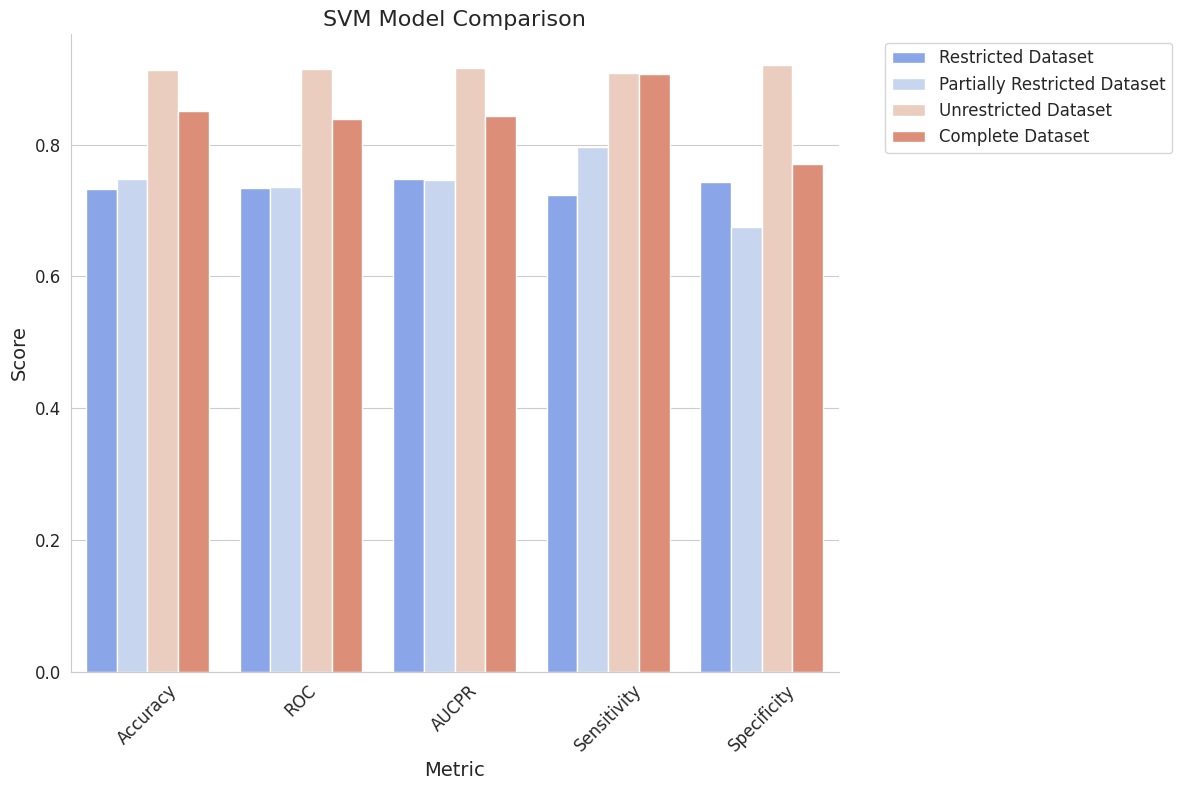

In [17]:
# SVM Results
svm_metrics = {
    "Accuracy": [res["Accuracy"]["mean"] for res in svm_results],
    "ROC": [res["ROC"]["mean"] for res in svm_results],
    "AUCPR": [res["AUCPR"]["mean"] for res in svm_results],
    "Sensitivity": [res["Sensitivity"]["mean"] for res in svm_results],
    "Specificity": [res["Specificity"]["mean"] for res in svm_results],
}
plot_model_comparison("SVM Model Comparison", svm_metrics.values(), subsets, metrics)

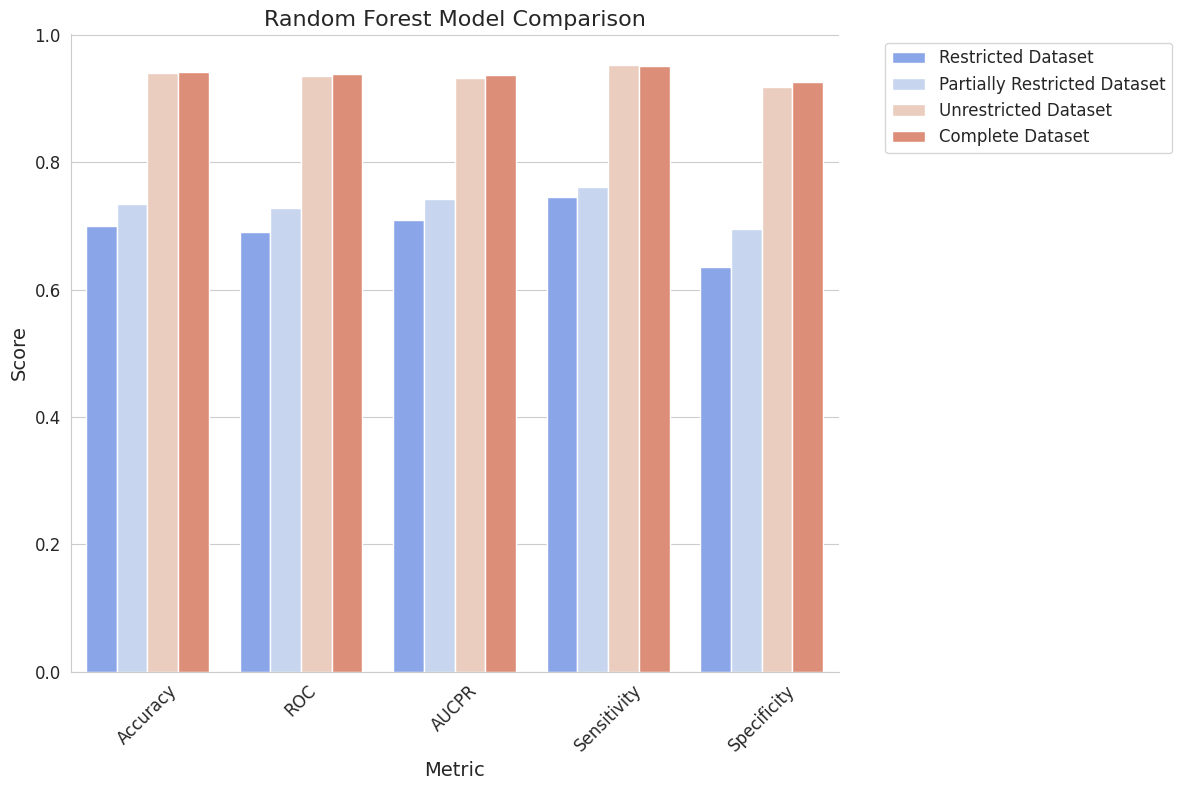

In [18]:
# Random Forest Results
rf_metrics = {
    "Accuracy": [res["Accuracy"]["mean"] for res in rf_results],
    "ROC": [res["ROC"]["mean"] for res in rf_results],
    "AUCPR": [res["AUCPR"]["mean"] for res in rf_results],
    "Sensitivity": [res["Sensitivity"]["mean"] for res in rf_results],
    "Specificity": [res["Specificity"]["mean"] for res in rf_results],
}
plot_model_comparison("Random Forest Model Comparison", rf_metrics.values(), subsets, metrics)

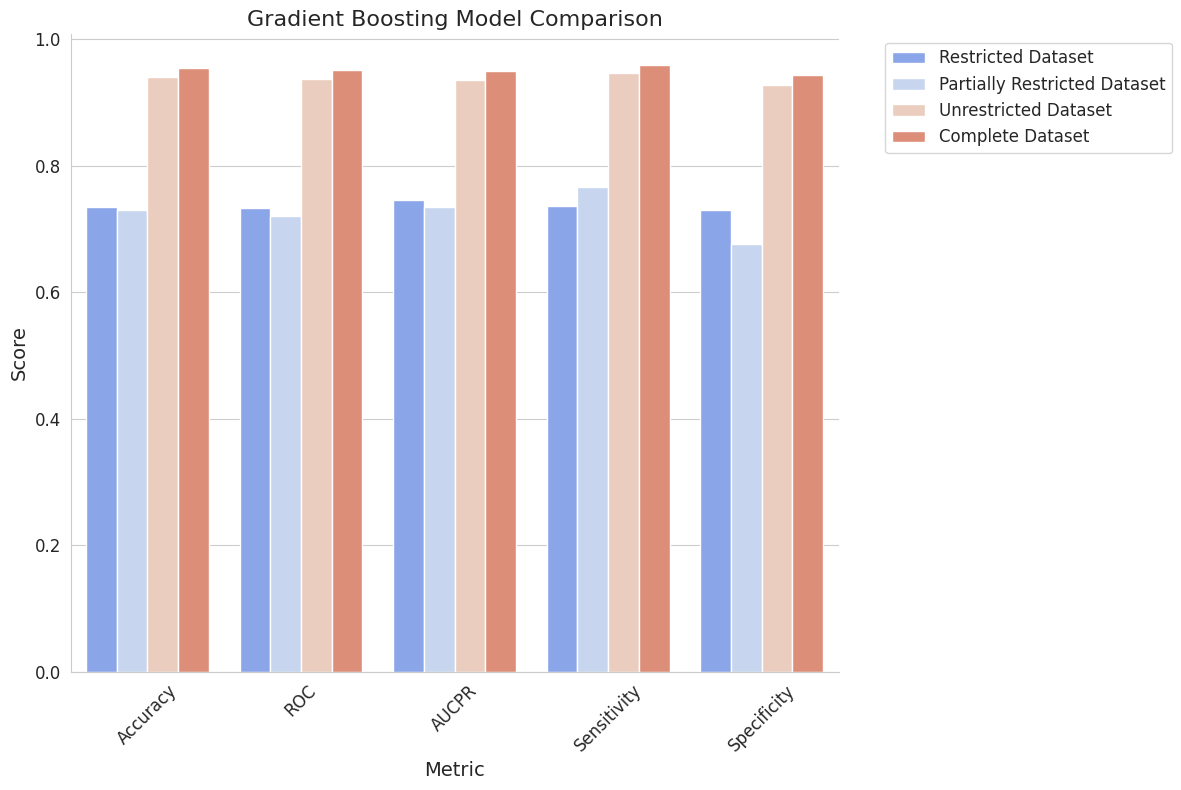

In [19]:
# Gradient Boosting Results
gb_metrics = {
    "Accuracy": [res["Accuracy"]["mean"] for res in gb_results],
    "ROC": [res["ROC"]["mean"] for res in gb_results],
    "AUCPR": [res["AUCPR"]["mean"] for res in gb_results],
    "Sensitivity": [res["Sensitivity"]["mean"] for res in gb_results],
    "Specificity": [res["Specificity"]["mean"] for res in gb_results],
}
plot_model_comparison("Gradient Boosting Model Comparison", gb_metrics.values(), subsets, metrics)

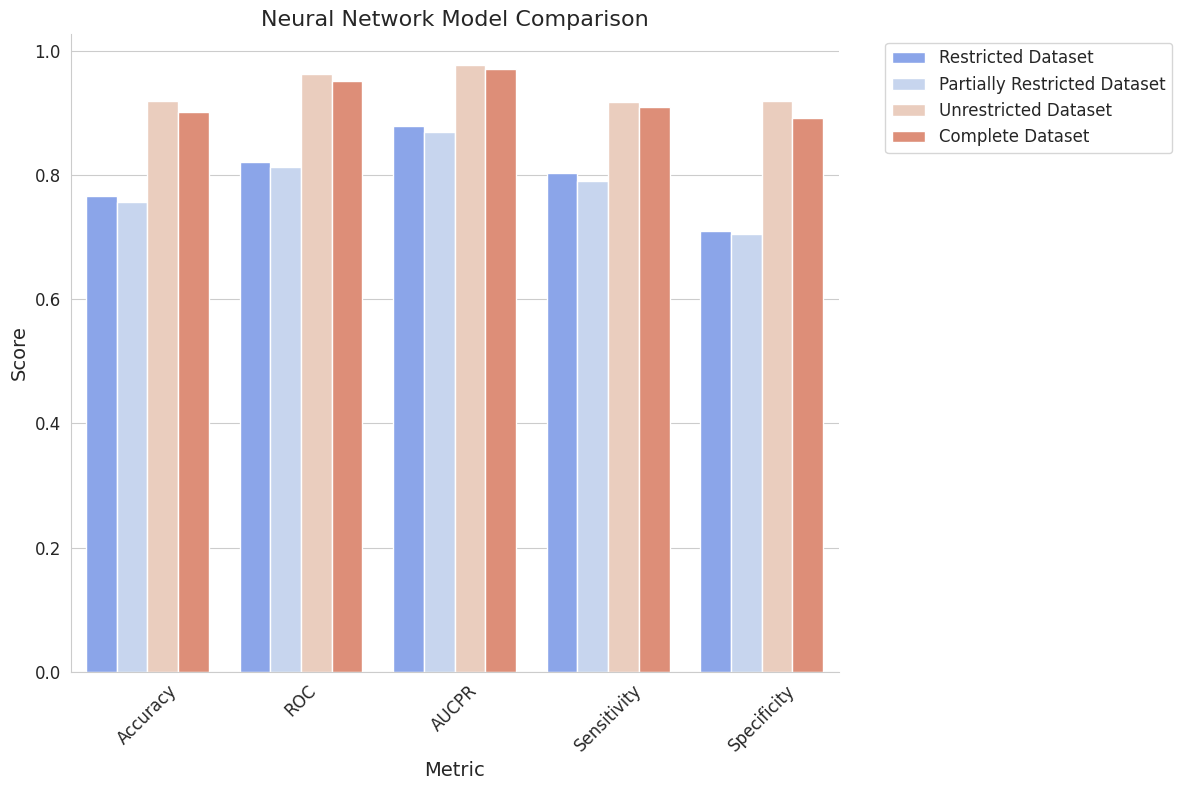

In [20]:
# Neural Network Results
nn_metrics = {
    "Accuracy": [res["Accuracy"]["mean"] for res in nn_results],
    "ROC": [res["ROC"]["mean"] for res in nn_results],
    "AUCPR": [res["AUCPR"]["mean"] for res in nn_results],
    "Sensitivity": [res["Sensitivity"]["mean"] for res in nn_results],
    "Specificity": [res["Specificity"]["mean"] for res in nn_results],
}
plot_model_comparison("Neural Network Model Comparison", nn_metrics.values(), subsets, metrics)